# Great Barrier Reef Object Detection

### Setup

In [1]:
!pip install -U -q tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 462 kB 2.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 10 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 22s (19.7 MB/s)
(Reading database ... 123934 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually sel

Use the NVIDIA System Management Interface to check the GPU device you are on.

In [2]:
!nvidia-smi

Mon Oct 10 22:37:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mount the drive to ensure access to where you store the images on Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [4]:
import pathlib
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import json
import zipfile
import shutil
import sys

from joblib import Parallel, delayed
import IPython
from PIL import Image, ImageDraw
import io
import contextlib2
import time
import tensorflow as tf

INPUT_DIR = '/content/greatbarrierreef'
sys.path.insert(0, INPUT_DIR)

Clone the tensorflow models repository so we can make use of a model that has already been trained.

In [5]:
# Clone the tensorflow models repositofy if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3492, done.
remote: Counting objects: 100% (3492/3492), done.
remote: Compressing objects: 100% (2914/2914), done.
remote: Total 3492 (delta 915), reused 1441 (delta 525), pack-reused 0
Receiving objects: 100% (3492/3492), 46.94 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (915/915), done.


Install dependencies of the pretrained models. 

In [6]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q -U .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.




  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


### Load and examine data

In [7]:
api_token = {"username":"","key":""}

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!echo '{"username":"USERNAME","key":"API_KEY"}' > /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
! kaggle competitions download -c tensorflow-great-barrier-reef

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
100% 14.2G/14.2G [04:14<00:00, 92.1MB/s]
100% 14.2G/14.2G [04:14<00:00, 59.9MB/s]


In [8]:
# Unzip Dataset
zip_ref = zipfile.ZipFile('/content/tensorflow-great-barrier-reef.zip','r')
zip_ref.extractall()
zip_ref.close()

In [9]:
os.remove('/content/tensorflow-great-barrier-reef.zip')

In [10]:
REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR = '/content'

Prepare the training dataset

In [12]:
SPLIT = 0.8

df = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv')) 

#split the dataset so that no sequence is leaked from the training dataset into the validation dataset.
split_index = int(SPLIT * len(df))
while df.iloc[split_index - 1].sequence == df.iloc[split_index].sequence:
  split_index += 1

# Shuffle both the training and validation datasets.
train_df = df.iloc[:split_index].sample(frac=1).reset_index(drop = True)
val_df = df.iloc[split_index:].sample(frac = 1).reset_index(drop = True)

train_pos_count = len(train_df[train_df.annotations != '[]'])
val_pos_count = len(val_df[val_df.annotations != '[]'])

print('Training ratio (all samples):',
      float(len(train_df)) / (len(train_df) + len(val_df)))
print('Training ratio (positive samples):',
      float(train_pos_count) / (train_pos_count + val_pos_count))

Training ratio (all samples): 0.8197523509637887
Training ratio (positive samples): 0.868265907704818


In [13]:
# Take only the positive images for training and validation.
train_df = train_df[train_df.annotations != '[]'].reset_index()
print('Number of positive images used for training:', len(train_df))
val_df = val_df[val_df.annotations != '[]'].reset_index()
print('Number of positive image used for validation:', len(val_df))

Number of positive images used for training: 4271
Number of positive image used for validation: 648


In [14]:
train_df.sample(5)

index  video_id  sequence  video_frame  sequence_frame image_id  \
2058   9279         0     53708         8922              37   0-8922   
4042  18156         0     35305         8233             579   0-8233   
3016  13463         0      8399         4495             757   0-4495   
2702  12052         1      8503         4068             240   1-4068   
1155   5164         1      8503         4083             255   1-4083   

                                            annotations  
2058  [{'x': 541, 'y': 550, 'width': 32, 'height': 27}]  
4042  [{'x': 682, 'y': 241, 'width': 34, 'height': 3...  
3016   [{'x': 82, 'y': 409, 'width': 51, 'height': 31}]  
2702  [{'x': 118, 'y': 300, 'width': 44, 'height': 36}]  
1155   [{'x': 540, 'y': 94, 'width': 18, 'height': 18}]

Visualize one randomly selected image from the training data.

/content/train_images/video_0/4641.jpg
[{'x': 683, 'y': 27, 'width': 23, 'height': 21}]


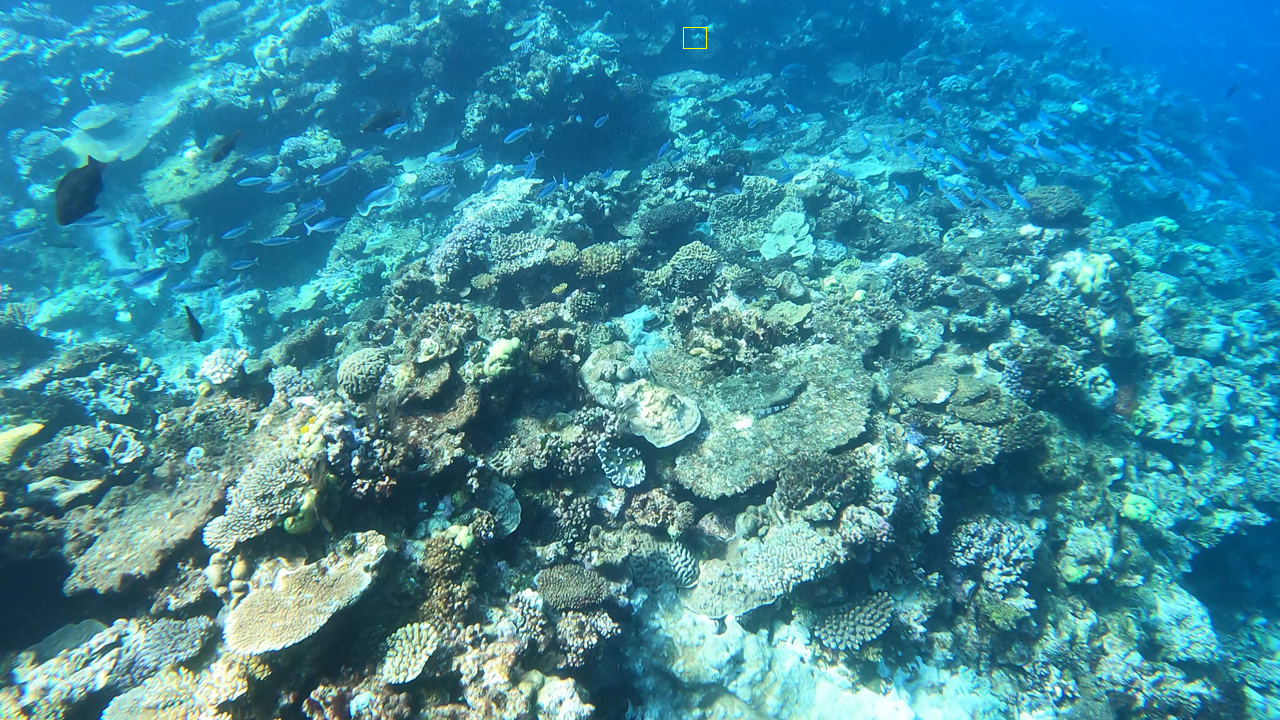

In [15]:
def image_with_annotation(video_id, video_frame, data_df, image_path):
    """Visualize annotations of a given image."""
    full_path = os.path.join(image_path, os.path.join(f'video_{video_id}', f'{video_frame}.jpg'))
    print(full_path)
    image = Image.open(full_path)
    draw = ImageDraw.Draw(image)

    rows = data_df[(data_df.video_id == video_id) & (data_df.video_frame == video_frame)]
    for _, row in rows.iterrows():
        annotations = json.loads(row.annotations.replace("'", '"'))
        print(annotations)
        for annotation in annotations:
            draw.rectangle((
                annotation['x'], 
                annotation['y'],
                (annotation['x'] + annotation['width']), 
                (annotation['y'] + annotation['height']),
                ), outline=(255, 255, 0))
        
    buf = io.BytesIO()
    image.save(buf, 'PNG')
    data = buf.getvalue()

    return data

# Test visualization of a randomly selected image
image_path = os.path.join(ROOT_DIR, 'train_images')
test_index = 70
video_id = train_df.iloc[test_index].video_id
video_frame = train_df.iloc[test_index].video_frame
IPython.display.Image(image_with_annotation(video_id, video_frame, df, image_path))

Images to numpy array

In [16]:
train_df['img_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
train_df.sample(5)

index  video_id  sequence  video_frame  sequence_frame image_id  \
475    2117         1      8503         5238            1410   1-5238   
2985  13305         0      8399         4727             989   0-4727   
2549  11413         1     17665         6858              13   1-6858   
2122   9548         0     59337         1875              24   0-1875   
2722  12158         0     53708         9463             578   0-9463   

                                            annotations  \
475   [{'x': 694, 'y': 425, 'width': 67, 'height': 7...   
2985  [{'x': 414, 'y': 595, 'width': 67, 'height': 5...   
2549  [{'x': 535, 'y': 546, 'width': 67, 'height': 6...   
2122  [{'x': 355, 'y': 312, 'width': 41, 'height': 31}]   
2722  [{'x': 328, 'y': 569, 'width': 56, 'height': 3...   

                                    img_path  
475    /content/train_images/video_0/475.jpg  
2985  /content/train_images/video_0/4908.jpg  
2549  /content/train_images/video_0/4472.jpg  
2122  /content/train_images/video_0/4045.jpg  
2722  /content/train_images/video_0/4645.jpg

In [17]:
len(train_df)

4271

Convert the training and validation dataset into TFRecord format as required by the Tensorflow Object Detection API.

In [ ]:
from object_detection.utils import dataset_util
from object_detection.dataset_tools import tf_record_creation_util

def create_tf_example(video_id, video_frame, data_df, image_path):
  full_path = os.path.join(image_path, os.path.join(f'video_{video_id}', f'{video_frame}.jpg'))
  with tf.io.gfile.GFile(full_path, 'rb') as fid:
    encoded_jpg = fid.read()
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = Image.open(encoded_jpg_io)
  if image.format != 'JPEG':
    raise ValueError('Image format not JPEG')

  height = image.size[1] #Image height
  width = image.size[0] #Image width
  filename = f'{video_id}:{video_frame}'.encode('utf8') #unique id of the image.
  encoded_image_data = None # Encoded image bytes
  image_format = 'jpeg'.encode('utf8') #b 'jpeg' or b'png'

  xmins = [] # list of normalized left x coordinates in bounding box (1 per box)
  xmaxs = [] # list of normalized right x coordinates in bounding box (1 per box)
  ymins = [] # list of normalized top y coordinates in bounding box (1 per box)
  ymaxs = [] # list of normalized bottom y coordinates in bounding box (1 per box)

  classes_text = [] # list of string class name of bounding box (1 per box)
  classes = [] # list of integer class id of bounding box (1 per box)

  rows = data_df[(data_df.video_id == video_id) & (data_df.video_frame == video_frame)]
  for _, row in rows.iterrows():
    annotations = json.loads(row.annotations.replace("'", '"'))
    for annotation in annotations:
      xmins.append(annotation['x'] / width)
      xmaxs.append((annotation['x'] + annotation['width']) / width)
      ymins.append(annotation['y'] / height)
      ymaxs.append((annotation['y'] + annotation['height']) / height)

      classes_text.append('COTS'.encode('utf8'))
      classes.append(1)

  tf_example = tf.train.Example(features = tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))

  return tf_example

def convert_to_tfrecord(data_df, tfrecord_filebase, image_path, num_shards = 10):
  """Convert the object detection dataset to TFRecord as required by the TF ODT API."""
  with contextlib2.ExitStack() as tf_record_close_stack:
    output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
        tf_record_close_stack, tfrecord_filebase, num_shards)
    
    for index, row in data_df.iterrows():
      if index % 500 == 0:
        print('Processed {0} images.'.format(index))
      tf_example = create_tf_example(row.video_id, row.video_frame, data_df, image_path)
      output_shard_index = index % num_shards
      output_tfrecords[output_shard_index].write(tf_example.SerializeToString())

    print('Completed processing {0} images.'.format(len(data_df)))

!mkdir dataset
image_path = os.path.join(ROOT_DIR, 'train_images')

# Convert train images to TFRecord
print('Converting TRAIN images...')
convert_to_tfrecord(
    train_df,
    'dataset/cots_train',
    image_path,
    num_shards = 4
)

# Convert validation images TFRecord
print('Converting VALIDATION images...')
convert_to_tfrecord(
    val_df, 
    'dataset/cots_val',
    image_path,
    num_shards = 4
)
  

mkdir: cannot create directory ‘dataset’: File exists
Converting TRAIN images...
Processed 0 images.
Processed 500 images.
Processed 1000 images.
Processed 1500 images.
Processed 2000 images.
Processed 2500 images.
Processed 3000 images.
Processed 3500 images.
Processed 4000 images.
Completed processing 4271 images.
Converting VALIDATION images...
Processed 0 images.
Processed 500 images.
Completed processing 648 images.


In [ ]:
# Create a label map to map between label index and human-readable label name.

label_map_str = """item {
  id: 1
  name: 'COTS'
}"""

with open('dataset/label_map.pbtxt', 'w') as f:
  f.write(label_map_str)

!more dataset/label_map.pbtxt

item {
  id: 1
  name: 'COTS'
}


### Train an object detection model

We'll use TensorFlow Object Detection API and an EfficientDet-D0 base model and apply transfer learning to train a COTS detection model. EfficientDet-D0 is the smallest model in the EfficientDet model family and we pick it to reduce training time for demonstration purpose. You can probably increase accuracy by switch to using a larger EfficientDet model.

In [ ]:
# Download the pretrained EfficientDet-D0 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz

--2022-10-10 20:19:39--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.200.128, 2404:6800:4003:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.200.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2022-10-10 20:19:39 (280 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficientdet_d

In [ ]:
from string import Template

config_file_template = """
# SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Initialized from an EfficientDet-D0 checkpoint.
#
# Train on GPU

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: [1.0, 2.0, 0.5]
        scales_per_octave: 3
      }
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 1280
        max_dimension: 1280
        pad_to_max_dimension: true
        }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        depth: 64
        class_prediction_bias_init: -4.6
        conv_hyperparams {
          force_use_bias: true
          activation: SWISH
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            random_normal_initializer {
              stddev: 0.01
              mean: 0.0
            }
          }
          batch_norm {
            scale: true
            decay: 0.99
            epsilon: 0.001
          }
        }
        num_layers_before_predictor: 3
        kernel_size: 3
        use_depthwise: true
      }
    }
    feature_extractor {
      type: 'ssd_efficientnet-b0_bifpn_keras'
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
      conv_hyperparams {
        force_use_bias: true
        activation: SWISH
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          scale: true,
          decay: 0.99,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid_focal {
          alpha: 0.25
          gamma: 1.5
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    normalize_loc_loss_by_codesize: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  fine_tune_checkpoint: "efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint_type: "detection"
  batch_size: 2
  sync_replicas: false
  startup_delay_steps: 0
  replicas_to_aggregate: 1
  use_bfloat16: false
  num_steps: $training_steps
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 1280
      scale_min: 0.5
      scale_max: 2.0
    }
  }
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: 5e-3
          total_steps: $training_steps
          warmup_learning_rate: 5e-4
          warmup_steps: $warmup_steps
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}

train_input_reader: {
  label_map_path: "dataset/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "dataset/cots_train-?????-of-00004"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 2;
}

eval_input_reader: {
  label_map_path: "dataset/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "dataset/cots_val-?????-of-00004"
  }
}
"""

In [ ]:
# Define the training pipeline
TRAINING_STEPS = 20000
WARMUP_STEPS = 2000
PIPELINE_CONFIG_PATH = 'dataset/pipeline.config'

pipeline = Template(config_file_template).substitute(
    training_steps = TRAINING_STEPS, warmup_steps = WARMUP_STEPS
)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
  f.write(pipeline)

In [ ]:
MODEL_DIR = 'cots_efficientdet_d0'
!mkdir {MODEL_DIR}
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr

2022-10-10 20:20:20.847010: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 20:20:21.589455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-10-10 20:20:21.589548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-10-10 20:20:21.589564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you woul

### Evaluate the object detection model

In [ ]:
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --checkpoint_dir={MODEL_DIR} \
    --eval_timeout=0 \
    --alsologtostderr

### Export SavedModel 

In [ ]:
!python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir={MODEL_DIR} \
    --output_directory={MODEL_DIR}/output

2022-10-05 03:28:38.458178: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 03:28:39.187211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-10-05 03:28:39.187304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-10-05 03:28:39.187319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you woul

# Run inference on test images

In [18]:
MODEL = '/content/drive/MyDrive/Projects/COTS/cots_efficientdet_d0/output/saved_model'

In [19]:
# Load the TensorFlow COTS detection model into memory.
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn_tf_odt = tf.saved_model.load(MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Model loaded successfully')
print('Elapsed time: ' + str(elapsed_time) + 's')

Model loaded successfully
Elapsed time: 37.38090467453003s


In [20]:
directory = "test_imgs"
test_imgs = os.path.join(ROOT_DIR,directory)

os.mkdir(test_imgs)

In [21]:
import random

source = os.path.join(image_path, f'video_{video_id}')
dest = test_imgs
files = os.listdir(source)
num_files = 10

for i in range(0,2):  
  for file_name in random.sample(os.listdir(os.path.join(image_path, f'video_{i}')), num_files):
    shutil.move(os.path.join(os.path.join(image_path, f'video_{i}'),file_name),dest)

In [22]:
from google.colab.patches import cv2_imshow
import cv2

def createBoundingBox(image, threshold = 0.5):
  inputTensor = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
  inputTensor = tf.convert_to_tensor(inputTensor, dtype = tf.uint8)
  inputTensor = inputTensor[tf.newaxis,...]

  detections = detect_fn_tf_odt(inputTensor)

  # convert image to numpy array
  bboxs = detections['detection_boxes'][0].numpy()
  classIndexes = detections['detection_classes'][0].numpy().astype(np.int32)
  classScores = detections['detection_scores'][0].numpy()

  img_h, img_w, img_c = image.shape

  bboxIdx = tf.image.non_max_suppression(bboxs, classScores, max_output_size = 10, iou_threshold=threshold, score_threshold = threshold)

  if len(bboxIdx) != 0:
    for i in bboxIdx:
      bbox = tuple(bboxs[i].tolist())
      classConfidence = round(100*classScores[i])
      classIndex = classIndexes[i]

      #classLabelText = classesList[classIndex]      
      #classColor = colorList[classIndex]

      #displayText = '{}: {}%'.format(classIndex, classConfidence)
      displayText = '{}: {}%'.format("COTS", classConfidence)


      ymin, xmin, ymax, xmax = bbox

      xmin, xmax, ymin, ymax = (xmin * img_w, xmax * img_w, ymin * img_h, ymax * img_h)
      xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)

      color = (255, 0, 0)

      cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness = 1)
      cv2.putText(image, displayText, (xmin, ymin-10), cv2.FONT_HERSHEY_PLAIN, 1, color, thickness = 2)

      #line width around the bbox
      lineWidth = min(int((xmax - xmin)*0.2), int((ymax - ymin) * 0.2))

      cv2.line(image, (xmin, ymin), (xmin + lineWidth, ymin), color, thickness = 5)
      cv2.line(image, (xmin, ymin), (xmin, ymin + lineWidth), color, thickness = 5)

      cv2.line(image, (xmax, ymin), (xmax - lineWidth, ymin), color, thickness = 5)
      cv2.line(image, (xmax, ymin), (xmax, ymin + lineWidth), color, thickness = 5)

      cv2.line(image, (xmin, ymax), (xmin + lineWidth, ymax), color, thickness = 5)
      cv2.line(image, (xmin, ymax), (xmin, ymax - lineWidth), color, thickness = 5)

      cv2.line(image, (xmax, ymax), (xmax - lineWidth, ymax), color, thickness = 5)
      cv2.line(image, (xmax, ymax), (xmax, ymax - lineWidth), color, thickness = 5)     

  return image

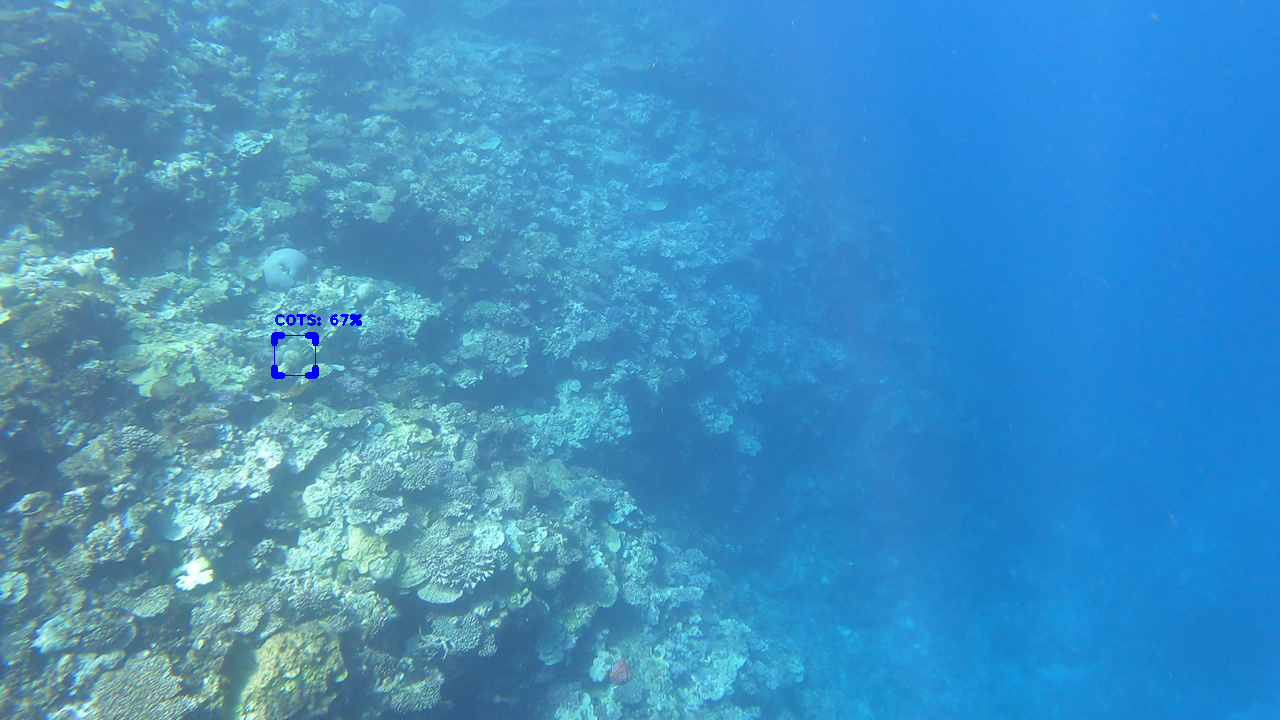

In [26]:
#test_path = '/content/test_imgs/10.jpg'
test_path = '/content/test_imgs/12211.jpg'

def predictImage(imagePath, threshold = 0.5):
  #image = cv2.imread(imagePath,cv2.IMREAD_UNCHANGED)
  image = cv2.imread(imagePath)
  #cv2_imshow(image)


  bboxImage = createBoundingBox(image, threshold)

  cv2_imshow(bboxImage)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

predictImage(test_path)